In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import math
from sklearn.preprocessing import MinMaxScaler
import pywt
from scipy.signal import medfilt

In [2]:
def denoise(data):
    #小波变换
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # 阈值去噪
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # 小波反变换,获取去噪后的信号
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

In [3]:
ours = pd.read_excel("./dataset/ecg_arduino.xlsx", header=None)
ours = ours.T
ours

,0,1,2,3,4,5,6,7,8,9,...,17148,17149,17150,17151,17152,17153,17154,17155,17156,17157
0,352.0,336.0,337.0,349.0,347.0,347.0,335.0,330.0,336.0,341.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,345.0,348.0,337.0,329.0,336.0,350.0,347.0,344.0,346.0,333.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,333.0,322.0,310.0,332.0,347.0,319.0,318.0,325.0,310.0,322.0,...,342.0,332.0,327.0,322.0,318.0,316.0,314.0,317.0,318.0,314.0


In [4]:
# normalization
def norm(X):
    for i in range(X.shape[0]):
        row = X[i, :]
        X[i, :] = (row - row.min())/(row.max()-row.min())
    return

In [5]:
def downsample(signal):
    downsample_signal = []
    signal_array = signal.to_numpy()
    
    for i in range(0,len(signal_array),2):
        downsample_signal.append(signal_array[i])
    
    return downsample_signal

In [6]:
from scipy import signal

def read_our_data(data):
    our_data = []
        
    for i in range(data.shape[0]):
        s = data.iloc[i, :]
        s = s.dropna()
        
#         down_signal = downsample(s)             # downsampling to 200 Hz
#         ecg_signal = down_signal[500:]          # drop 1000 unstable data
        ecg_signal = s
    
        # median filter
        filt = int(180*0.8)
        Filter = medfilt(ecg_signal, filt+1)
        signal_filt = ecg_signal - Filter


        # wavelet transform
        signal_denoise = denoise(signal_filt)
        
#         print(f'signal_denoise len = {len(signal_denoise)}')
        # splicing data into 370
        for i in range(0,len(signal_denoise), 351):
            if i + 351 >= len(signal_denoise):
                break
            tmp = signal_denoise[i:i+351]
            our_data.append(tmp)

            
    our_data = np.array(our_data)

    return our_data

<h2> Read our data and merged into normal dataset

In [7]:
our_data = read_our_data(ours)

In [8]:
our_data.shape

(113, 351)

In [9]:
covid = pd.read_csv('./dataset/Covid_lead I.csv', header=None)
normal = pd.read_csv('./dataset/Normal_lead I.csv', header=None)
covid = np.array(covid.T)
normal = np.array(normal.T)

In [10]:
from scipy import signal
covid = signal.resample(covid, 351, axis=1)
normal = signal.resample(normal, 351, axis=1)

In [11]:
from sklearn.model_selection import train_test_split

normal_dataset_train, normal_dataset_test = train_test_split(normal, train_size=0.8, shuffle=True)
our_data_train, our_data_test = train_test_split(our_data, train_size=0.8, shuffle=True)

<h2> Split COVID and NORMAL data for training data & test data

In [12]:
normal_X_train = np.concatenate((normal_dataset_train, our_data_train))
normal_X_test = np.concatenate((normal_dataset_test, our_data_test))
covid_X_train, covid_X_test = train_test_split(covid, train_size=0.8, shuffle=True)

In [13]:
normal_X_train.shape, normal_X_test.shape, covid_X_train.shape, covid_X_test.shape

((250, 351), (63, 351), (200, 351), (50, 351))

In [14]:
norm(normal_X_train)
norm(normal_X_test)
norm(covid_X_train)
norm(covid_X_test)

In [15]:
for i in range(200):
    noise = 0.05 * np.random.normal(0, 0.1, 351);
    noisySignal = covid_X_train[i] + noise;
    covid_X_train = np.vstack([covid_X_train, noisySignal])
    
    noise2 = 0.05 * np.random.normal(0, 0.2, 351);
    noisySignal2 = covid_X_train[i] + noise2;
    covid_X_train = np.vstack([covid_X_train, noisySignal2])
    
    noise3 = 0.05 * np.random.normal(0, 0.3, 351);
    noisySignal3 = covid_X_train[i] + noise3;
    covid_X_train = np.vstack([covid_X_train, noisySignal3])
for i in range(250):
    noise1 = 0.05 * np.random.normal(0, 0.1, 351);
    noisySignal1 = normal_X_train[i] + noise1;
    normal_X_train = np.vstack([normal_X_train, noisySignal1])
    
    noise2 = 0.05 * np.random.normal(0, 0.2, 351);
    noisySignal2 = normal_X_train[i] + noise2;
    normal_X_train = np.vstack([normal_X_train, noisySignal2])
    
    noise3 = 0.05 * np.random.normal(0, 0.3, 351);
    noisySignal3 = normal_X_train[i] + noise3;
    normal_X_train = np.vstack([normal_X_train, noisySignal3])

In [16]:
normal_Y_train = np.zeros(len(normal_X_train))
normal_Y_test = np.zeros(len(normal_X_test))
covid_Y_train = np.ones(len(covid_X_train))
covid_Y_test = np.ones(len(covid_X_test))

In [17]:
X_train = np.concatenate((normal_X_train, covid_X_train))
Y_train = np.concatenate((normal_Y_train, covid_Y_train))
X_test = np.concatenate((normal_X_test, covid_X_test))
Y_test = np.concatenate((normal_Y_test, covid_Y_test))

<h2> make X_data type to 0 ~ 255

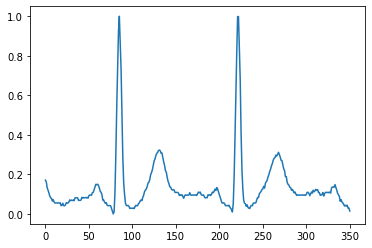

In [18]:
plt.plot(X_train[0])

In [19]:
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
        X_train[i][j] = min(255, int(X_train[i][j]*255))
        
for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
        X_test[i][j] = min(255, int(X_test[i][j]*255))       

<h2> Get testsamples on board ( 0~ 255 without minus 128 ).

In [20]:
# X_test_board = np.concatenate((X_test[0:25], X_test[4542:4542+25]))
# Y_test_board = np.concatenate((np.zeros(25), np.ones(25)))

<h2> make data to -128 ~ 127

In [21]:
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
        X_train[i][j] = X_train[i][j] - 128
        
for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
        X_test[i][j] = X_test[i][j] - 128

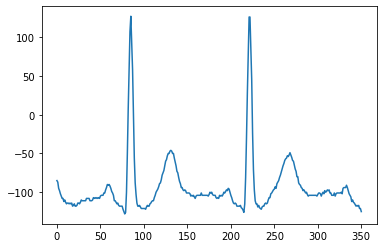

In [22]:
plt.plot(X_train[0])

<h2> Suffle

In [23]:
import random
def shuffle_array(X, Y):
    shuffle_index= np.arange(X.shape[0])
    random.shuffle(shuffle_index)
    shuffle_X = X[shuffle_index]
    shuffle_Y = Y[shuffle_index]
    return shuffle_X, shuffle_Y

In [24]:
X_train, Y_train = shuffle_array(X_train, Y_train)
X_test, Y_test   = shuffle_array(X_test, Y_test)

In [25]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1800, 351), (1800,), (113, 351), (113,))

In [26]:
from keras.utils.np_utils import *
Y_train = to_categorical(Y_train, 2)
Y_test = to_categorical(Y_test, 2)
print(Y_train.shape, Y_test.shape)

(1800, 2) (113, 2)


<h2> CNN model

In [27]:
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1],1,1)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1],1,1)

In [28]:
X_test_reshaped.shape, X_train_reshaped.shape

((113, 351, 1, 1), (1800, 351, 1, 1))

In [29]:
# X_test_reshaped = X_test_reshaped.astype(np.uint8)
# X_train_reshaped = X_train_reshaped.astype(np.uint8)

In [54]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint


keras.backend.clear_session()

def build_model():
    model = Sequential()
    model.add(Conv2D(filters=8, kernel_size=(3,1), padding='same', activation='relu', input_shape=(351, 1,1)))
    model.add(MaxPooling2D(pool_size=(3,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=16, kernel_size=(3,1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,1)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(4, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_model()

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 351, 1, 8)         32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 117, 1, 8)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 117, 1, 8)         32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 117, 1, 16)        400       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 39, 1, 16)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 39, 1, 16)         64        
_________________________________________________________________
flatten (Flatten)            (None, 624)               0

In [56]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_function = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5, min_lr=0.000000001)
callbacks_list = [learning_rate_function]
history = model.fit(X_train_reshaped, Y_train, epochs=70, validation_split=0.2, verbose=1, callbacks=callbacks_list)

Epoch 1/70
45/45 [==============================] - 0s 11ms/step - loss: 0.5363 - accuracy: 0.7188 - val_loss: 1.4182 - val_accuracy: 0.5056
Epoch 2/70
45/45 [==============================] - 0s 7ms/step - loss: 0.2722 - accuracy: 0.8938 - val_loss: 0.8658 - val_accuracy: 0.6444
Epoch 3/70
45/45 [==============================] - 0s 7ms/step - loss: 0.1603 - accuracy: 0.9431 - val_loss: 0.2589 - val_accuracy: 0.9056
Epoch 4/70
45/45 [==============================] - 0s 6ms/step - loss: 0.1143 - accuracy: 0.9563 - val_loss: 0.1807 - val_accuracy: 0.9250
Epoch 5/70
45/45 [==============================] - 0s 6ms/step - loss: 0.0751 - accuracy: 0.9715 - val_loss: 0.0918 - val_accuracy: 0.9694
Epoch 6/70
45/45 [==============================] - 0s 7ms/step - loss: 0.0616 - accuracy: 0.9729 - val_loss: 0.0801 - val_accuracy: 0.9639
Epoch 7/70
45/45 [==============================] - 0s 7ms/step - loss: 0.0469 - accuracy: 0.9764 - val_loss: 0.0594 - val_accuracy: 0.9694
Epoch 8/70
45/45 [=

Epoch 57/70
41/45 [==========================>...] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000
Epoch 00057: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
45/45 [==============================] - 0s 6ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0086 - val_accuracy: 0.9972
Epoch 58/70
45/45 [==============================] - 0s 6ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0079 - val_accuracy: 0.9972
Epoch 59/70
45/45 [==============================] - 0s 6ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0074 - val_accuracy: 0.9972
Epoch 60/70
45/45 [==============================] - 0s 7ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0069 - val_accuracy: 0.9972
Epoch 61/70
45/45 [==============================] - 0s 7ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0073 - val_accuracy: 0.9972
Epoch 62/70
39/45 [=========================>....] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000
Epoch 00062: ReduceLROnPlateau reduci

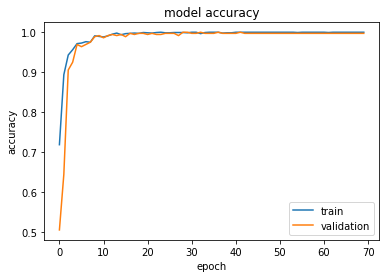

In [57]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

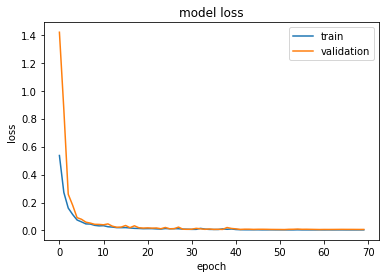

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [59]:
model2 = model
[loss, acc] = model2.evaluate(X_test_reshaped, Y_test, verbose=1)

4/4 [==============================] - 0s 2ms/step - loss: 0.3649 - accuracy: 0.9469


In [60]:
prediction = model2.predict(X_test_reshaped)
classes = np.argmax(prediction, axis=1)
classes

array([1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0], dtype=int64)

In [61]:
# print(*classes, sep=',')

In [62]:
ans = [int(i) for i in Y_test[:, 1]]

In [63]:
# print(*ans, sep=',')

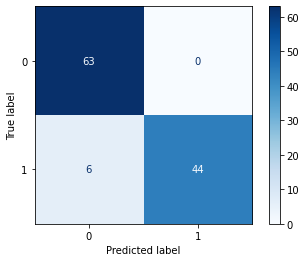

In [64]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(ans, classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

<h1> converted to tflite

In [65]:
model2.save('model_save')

INFO:tensorflow:Assets written to: model_save\assets


INFO:tensorflow:Assets written to: model_save\assets


In [66]:
model_test = keras.models.load_model('model_save')

# Model Evaluation
score = model_test.evaluate(X_test_reshaped, Y_test, verbose = 0)
print('test loss', score[0])
print('accuracy', score[1])

test loss 0.3649439215660095
accuracy 0.9469026327133179


## Quantization

In [67]:
model = model_test

In [68]:
# tensorflow lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\陳奕帆\AppData\Local\Temp\tmpuyuh23p1\assets


INFO:tensorflow:Assets written to: C:\Users\陳奕帆\AppData\Local\Temp\tmpuyuh23p1\assets


In [69]:
train_data = tf.cast(X_test_reshaped, tf.float32)
# train_data = X_train_reshaped
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_data).batch(1).take(100):
    # Model has only one input so each data point has one element.
        yield [input_value]

In [70]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.representative_dataset = representative_data_gen

tflite_model_quant_int8 = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\陳奕帆\AppData\Local\Temp\tmpaekjflg6\assets


INFO:tensorflow:Assets written to: C:\Users\陳奕帆\AppData\Local\Temp\tmpaekjflg6\assets


In [71]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant_int8)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.int8'>
output:  <class 'numpy.int8'>


In [72]:
import pathlib

tflite_models_dir = pathlib.Path("generated/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_quant_file_int8 = tflite_models_dir/"tflite_model_quant_int8.tflite"
tflite_model_quant_file_int8.write_bytes(tflite_model_quant_int8)

9664

## Evaluate TensorFlow Lite Quant (int8) Model

In [73]:
def evaluate_model(interpreter, X_test, Y_test):
#     X_test_data = tf.cast(X_test, tf.float32)

    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    scale, zero_point = interpreter.get_input_details()[0]['quantization']

    prediction_values = []
    
    i=0
    for test_data in X_test:
#         print('Processing '+str(i)+' data');
        # Pre-processing: add batch dimension, quantize and convert inputs to int8 to match with
        # the model's input data format.
        test_data = np.expand_dims(test_data, axis=0)#.astype(interpreter.get_input_details()[0]["dtype"])
        test_data = np.int8(test_data / scale + zero_point)
        interpreter.set_tensor(input_index, test_data)

        interpreter.invoke()

        # Find the letter with highest probability
        output = interpreter.tensor(output_index)
#         print(output())
        result = np.argmax(output()[0])
        prediction_values.append(result)
        i = i + 1
    
    print(prediction_values)
    accurate_count = 0
    for index in range(len(prediction_values)):
        if prediction_values[index] == Y_test[index]:
            accurate_count += 1
    accuracy = accurate_count * 1.0 / len(prediction_values)

    return accuracy * 100

In [74]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_quant_file_int8))
interpreter.allocate_tensors()

print(str(evaluate_model(interpreter, X_test_reshaped, Y_test[:,1])) + "%")

[1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]
94.69026548672566%


<h2> Transfer test data to Cpp

In [75]:
# X_test_board.shape, Y_test_board.shape

In [76]:
# samples_file = open("generated/test_samples.cpp", "w")

# samples_file.write("#include \"test_samples.h\"\n\n")
# samples_file.write("const int kNumSamples = " + str(50) + ";\n\n")

# samples = "" 
# samples_array = "const TestSample test_samples[kNumSamples] = {"

# for index in range(50):
#     data_arr = list(np.ndarray.flatten(X_test_board[index]))
#     data_arr = [int(i) for i in data_arr]
#     var_name = "sample" + str(index+1)
#     samples += "TestSample " + var_name + " = {\n" #+ "[IMAGE_SIZE] = { "
#     samples += "\t.label = " + str(int(Y_test_board[index])) + ",\n" 
#     samples += "\t.image = {\n"
#     wrapped_arr = [data_arr[i:i + 10] for i in range(0, len(data_arr), 10)]
#     for sub_arr in wrapped_arr:
#         samples += "\t\t" + str(sub_arr)
#     samples += "\t}\n};\n\n"    
#     samples_array += var_name + ", "
    
# samples = samples.replace("[", "")
# samples = samples.replace("]", ",\n")
# samples_array += "};\n"

# samples_file.write(samples);
# samples_file.write(samples_array);
# samples_file.close()

In [77]:
# samples_file = open("generated/test_samples_2.cpp", "w")

# samples_file.write("#include \"test_samples.h\"\n\n")
# samples_file.write("const int kNumSamples = " + str(X_test_reshaped.shape[0]) + ";\n\n")

# samples = "" 
# samples_array = "const TestSample test_samples[kNumSamples] = {"

# for index in range(X_test_reshaped.shape[0]):
#     data_arr = list(np.ndarray.flatten(X_test_reshaped[index]))
#     data_arr = [int(i) for i in data_arr]
#     var_name = "sample" + str(index+1)
#     samples += "TestSample " + var_name + " = {\n" #+ "[IMAGE_SIZE] = { "
#     samples += "\t.label = " + str(int(Y_test[index,1])) + ",\n" 
#     samples += "\t.image = {\n"
#     wrapped_arr = [data_arr[i:i + 10] for i in range(0, len(data_arr), 10)]
#     for sub_arr in wrapped_arr:
#         samples += "\t\t" + str(sub_arr)
#     samples += "\t}\n};\n\n"    
#     samples_array += var_name + ", "
    
# samples = samples.replace("[", "")
# samples = samples.replace("]", ",\n")
# samples_array += "};\n"

# samples_file.write(samples);
# samples_file.write(samples_array);
# samples_file.close()